# Multilingual Toxic Comment Detection and Classification

# Baseline models

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import transformers
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from tensorflow.keras.callbacks import CSVLogger, Callback, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Loading the data

In [2]:
train_df = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
train_df.shape
train_df.head()

(223549, 8)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
val_df = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
val_df.shape
val_df.head()

(8000, 4)

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [4]:
test_df = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test_df.shape
test_df.head()

(63812, 3)

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


## Data preprocessing

In [5]:
# Function to remove usernames and links


def clean(text):
    # fill the missing entries and convert them to lower case
    text = text.fillna("fillna").str.lower()
    # replace the newline characters with space 
    text = text.map(lambda x: re.sub('\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    # remove usernames and links
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("",'',str(x)))
    return text

train_df["comment_text"] = clean(train_df["comment_text"])
val_df["comment_text"] = clean(val_df["comment_text"])
test_df["content"] = clean(test_df["content"])

## BERT Tokenizer

In [6]:
# Hyperparamters

AUTO = tf.data.experimental.AUTOTUNE
EPOCHS = 10
BATCH_SIZE = 128
MAX_LEN = 512

In [7]:
# Function to encode and pad the text

def encode(texts, tokenizer, text_len=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), text_len):
        text_val = texts[i:i+text_len].tolist()
        encode = tokenizer.encode_batch(text_val)
        all_ids.extend([enc.ids for enc in encode])
    
    return np.array(all_ids)

In [8]:
transformer = transformers.TFDistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

2022-12-14 20:59:43.955097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 20:59:43.956234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 20:59:43.956935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 20:59:43.959259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

2022-12-14 21:00:08.998565: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the 

In [9]:
distilbert_version = "distilbert-base-multilingual-cased"
tokenizer_pkg = transformers.DistilBertTokenizer.from_pretrained(distilbert_version)
save_path = "/kaggle/working/" + distilbert_version + "/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer_pkg.save_pretrained(save_path)
tokenizer = BertWordPieceTokenizer(distilbert_version + "/vocab.txt", lowercase=False)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

('/kaggle/working/distilbert-base-multilingual-cased/tokenizer_config.json',
 '/kaggle/working/distilbert-base-multilingual-cased/special_tokens_map.json',
 '/kaggle/working/distilbert-base-multilingual-cased/vocab.txt',
 '/kaggle/working/distilbert-base-multilingual-cased/added_tokens.json')

# Model data objects

In [10]:
def get_data(data):
  x = encode(data.comment_text.astype(str), 
                      tokenizer, maxlen=MAX_LEN)
  y = data.toxic.values
  return x, y

In [11]:
# Creating train data object for model

x_train, y_train = get_data(train_df)
train = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(230)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

x_train.shape, y_train.shape

2022-12-14 21:01:15.571644: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 915656704 exceeds 10% of free system memory.
2022-12-14 21:01:16.584495: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 915656704 exceeds 10% of free system memory.


((223549, 512), (223549,))

In [12]:
# Creating validation data object for model

x_valid, y_valid = get_data(val_df)
valid = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

x_valid.shape, y_valid.shape

((8000, 512), (8000,))

# LSTM 2 layers

In [13]:
# Account for the class imbalance

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.5528874928894715, 1: 5.227015525626637}

In [14]:
# Function to calculate ROC-AUC for each epoch

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.x_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [15]:
# Function to log callbacks

def get_callbacks(log_filepath="log.csv"):
  rocauc = RocAucEvaluation((x_valid, y_valid), interval=1)
  log = CSVLogger(log_filepath)
  reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                      factor=0.3, patience=3, 
                                      verbose=1, mode='auto', 
                                      epsilon=0.0001, cooldown=1, min_lr=0.000001)

  return [reduceLROnPlat,log,rocauc,]

In [16]:
# Baseline model with 2 LSTM layers and 1 dense layer

input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
embed = transformer.weights[0].numpy()

lstm_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=False),
    tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True),
    tf.keras.layers.LSTM(BATCH_SIZE),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
    
lstm_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 768)          91812096  
_________________________________________________________________
lstm (LSTM)                  (None, 512, 128)          459264    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 92,419,585
Trainable params: 607,489
Non-trainable params: 91,812,096
_________________________________________________________________


In [17]:
# Evaluation metrics

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [18]:
# Compiling the model

lstm_2.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=METRICS)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
# EPOCHS = 10

In [20]:
# Fitting the model

history1 = lstm_2.fit(train, epochs=EPOCHS,steps_per_epoch=BATCH_SIZE, class_weight=class_weights, callbacks=get_callbacks("/kaggle/working/lstm_2_log.csv"), validation_data=valid)

2022-12-14 21:01:21.058413: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 915656704 exceeds 10% of free system memory.
2022-12-14 21:01:22.030968: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-14 21:01:25.834402: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 [==============================] - 20s 125ms/step - loss: 0.6951 - accuracy: 0.4889 - precision: 0.0964 - recall: 0.5169 - auc: 0.5004 - val_loss: 0.6993 - val_accuracy: 0.1538 - val_precision: 0.1538 - val_recall: 1.0000 - val_auc: 0.4995

 ROC-AUC - epoch: 1 - score: 0.499446
Epoch 2/10
128/128 [==============================] - 15s 118ms/step - loss: 0.7076 - accuracy: 0.4057 - precision: 0.1013 - recall: 0.6282 - auc: 0.5075 - val_loss: 0.6778 - val_accuracy: 0.8462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5013

 ROC-AUC - epoch: 2 - score: 0.503143
Epoch 3/10
128/128 [==============================] - 15s 118ms/step - loss: 0.6992 - accuracy: 0.1961 - precision: 0.0979 - recall: 0.8828 - auc: 0.5019 - val_loss: 0.6798 - val_accuracy: 0.8455 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4993

 ROC-AUC - epoch: 3 - score: 0.497969
Epoch 4/10
128/128 [==============================] - 15s 118ms/step - loss: 0.6879 - accuracy: 0.708

In [21]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ax[0].set_title('Model AUC')
# ax[0].plot(history1.history['auc'])
# ax[0].plot(history1.history['val_auc'])
# ax[0].set_xlabel("epochs")
# ax[0].set_ylabel("auc")
# plt.legend(['train', 'validation'], loc='upper left')

# ax[1].set_title('Model loss')
# ax[1].plot(history1.history['loss'])
# ax[1].plot(history1.history['val_loss'])
# ax[1].set_xlabel("epochs")
# ax[1].set_ylabel("loss")
# plt.legend(['train', 'validation'], loc='upper left')

# LSTM 4 layers

In [22]:
# Model with 4 LSTM layers and 2 dense layers

lstm_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=False),
    
    tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True, dropout=0.2),
    tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True, dropout=0.2),
    tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True, dropout=0.2),
    tf.keras.layers.LSTM(BATCH_SIZE, dropout=0.2),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
   
lstm_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 768)          91812096  
_________________________________________________________________
lstm_2 (LSTM)                (None, 512, 128)          459264    
_________________________________________________________________
lstm_3 (LSTM)                (None, 512, 128)          131584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 512, 128)          131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

In [23]:
# Compiling the model

lstm_4.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=METRICS)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
# Fitting the model

history2 = lstm_4.fit(train, epochs=EPOCHS,steps_per_epoch=BATCH_SIZE, class_weight=class_weights, callbacks=get_callbacks("/kaggle/working/lstm_4_log.csv"),
                    validation_data=valid)

2022-12-14 21:05:48.104083: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 915656704 exceeds 10% of free system memory.


Epoch 1/10
128/128 [==============================] - 35s 236ms/step - loss: 0.6931 - accuracy: 0.5880 - precision: 0.0961 - recall: 0.3090 - auc: 0.4940 - val_loss: 0.6926 - val_accuracy: 0.8446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000

 ROC-AUC - epoch: 1 - score: 0.498743
Epoch 2/10
128/128 [==============================] - 29s 224ms/step - loss: 0.7094 - accuracy: 0.3728 - precision: 0.0991 - recall: 0.6476 - auc: 0.4897 - val_loss: 0.6907 - val_accuracy: 0.8462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5006

 ROC-AUC - epoch: 2 - score: 0.501143
Epoch 3/10
128/128 [==============================] - 29s 225ms/step - loss: 0.6997 - accuracy: 0.1823 - precision: 0.0976 - recall: 0.8943 - auc: 0.4883 - val_loss: 0.6873 - val_accuracy: 0.8462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4998

 ROC-AUC - epoch: 3 - score: 0.499226
Epoch 4/10
128/128 [==============================] - 29s 225ms/step - loss: 0.690

In [25]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'lr'])

In [26]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ax[0].set_title('Model AUC')
# ax[0].plot(history2.history['auc_1'])
# ax[0].plot(history2.history['val_auc_1'])
# ax[0].set_xlabel("epchs")
# ax[0].set_ylabel("auc")
# plt.legend(['train', 'validation'], loc='upper left')

# ax[1].set_title('Model loss')
# ax[1].plot(history2.history['loss'])
# ax[1].plot(history2.history['val_loss'])
# ax[1].set_xlabel("epochs")
# ax[1].set_ylabel("loss")
# plt.legend(['train', 'validation'], loc='upper left')

In [27]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'lr'])

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Train Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Validation ROC-AUC')

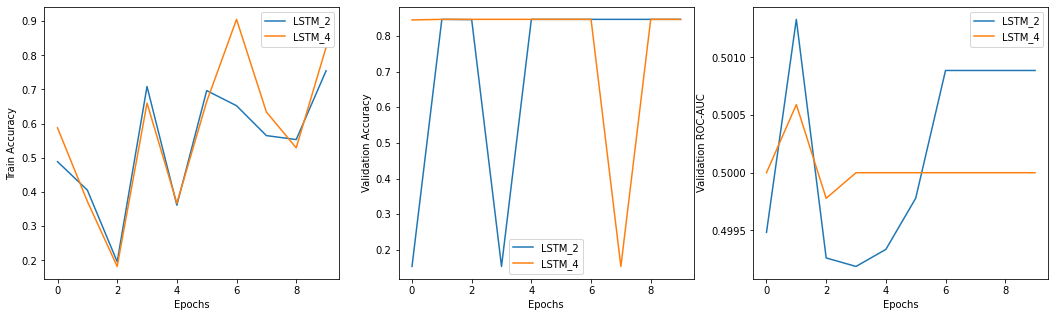

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(history1.history['accuracy'])
ax[0].plot(history2.history['accuracy'])
# ax[0].plot(history3.history['acc'])
# ax[0].plot(history4.history['acc'])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Train Accuracy")
ax[0].legend(['LSTM_2', 'LSTM_4'])

ax[1].plot(history1.history['val_accuracy'])
ax[1].plot(history2.history['val_accuracy'])
# ax[1].plot(history3.history['val_acc'])
# ax[1].plot(history4.history['val_acc'])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Validation Accuracy")
ax[1].legend(['LSTM_2', 'LSTM_4'])

ax[2].plot(history1.history['val_auc'])
ax[2].plot(history2.history['val_auc'])
# ax[2].plot(history3.history['val_auc_2'])
# ax[2].plot(history4.history['val_auc_3'])
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Validation ROC-AUC")
ax[2].legend(['LSTM_2', 'LSTM_4'])

# Bi-LSTM 2 layers

In [29]:
# Model with 2 Bi-LSTM layers and 2 dense layers

bilstm_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True, dropout=0.3)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, dropout=0.3)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
bilstm_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 512, 768)          91812096  
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 256)          918528    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 93,161,921
Trainable params: 1,349,825
Non-trainable params: 91,812,096
__________________________________

In [30]:
# Compiling the model

bilstm_2.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=METRICS)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [31]:
# Fitting the model

history3 = bilstm_2.fit(train, epochs=EPOCHS, steps_per_epoch=BATCH_SIZE, class_weight=class_weights,callbacks=get_callbacks("/kaggle/working/bilstm_2_logs.csv"),
                    validation_data=valid)

2022-12-14 21:12:28.654691: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 915656704 exceeds 10% of free system memory.


Epoch 1/10
128/128 [==============================] - 41s 282ms/step - loss: 0.5016 - accuracy: 0.7961 - precision: 0.2575 - recall: 0.4121 - auc: 0.7531 - val_loss: 1.8206 - val_accuracy: 0.2240 - val_precision: 0.1622 - val_recall: 0.9715 - val_auc: 0.6640

 ROC-AUC - epoch: 1 - score: 0.664146
Epoch 2/10
128/128 [==============================] - 35s 271ms/step - loss: 0.4082 - accuracy: 0.8399 - precision: 0.3661 - recall: 0.8217 - auc: 0.8975 - val_loss: 1.5863 - val_accuracy: 0.2558 - val_precision: 0.1687 - val_recall: 0.9780 - val_auc: 0.6772

 ROC-AUC - epoch: 2 - score: 0.677731
Epoch 3/10
128/128 [==============================] - 35s 271ms/step - loss: 0.3831 - accuracy: 0.8412 - precision: 0.3633 - recall: 0.8353 - auc: 0.9094 - val_loss: 0.6749 - val_accuracy: 0.6511 - val_precision: 0.2490 - val_recall: 0.6293 - val_auc: 0.6966

 ROC-AUC - epoch: 3 - score: 0.696592
Epoch 4/10
128/128 [==============================] - 35s 272ms/step - loss: 0.3303 - accuracy: 0.8420 - p

In [32]:
history3.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'lr'])

In [33]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ax[0].set_title('Model AUC')
# ax[0].plot(history3.history['auc_2'])
# ax[0].plot(history3.history['val_auc_2'])
# ax[0].set_xlabel("epchs")
# ax[0].set_ylabel("auc")
# plt.legend(['train', 'validation'], loc='upper left')

# ax[1].set_title('Model loss')
# ax[1].plot(history3.history['loss'])
# ax[1].plot(history3.history['val_loss'])
# ax[1].set_xlabel("epochs")
# ax[1].set_ylabel("loss")
# plt.legend(['train', 'validation'], loc='upper left')

# Bi-LSTM 4 layers

In [34]:
# Model with 4 LSTM layers and 2 dense layers

bilstm_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, dropout=0.2)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
bilstm_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 512, 768)          91812096  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512, 256)          918528    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512, 256)          394240    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512, 256)          394240    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 32)               

In [35]:
# Compiling the model

bilstm_4.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=METRICS)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
# Fitting the model

history4 = bilstm_4.fit(train, epochs=EPOCHS,
                        steps_per_epoch=BATCH_SIZE, class_weight=class_weights, callbacks=get_callbacks("/kaggle/working/bilstm_4_logs.csv"), validation_data=valid)

Epoch 1/10
128/128 [==============================] - 81s 561ms/step - loss: 0.4536 - accuracy: 0.7693 - precision: 0.2948 - recall: 0.7232 - auc: 0.8310 - val_loss: 1.2942 - val_accuracy: 0.2220 - val_precision: 0.1570 - val_recall: 0.9293 - val_auc: 0.5539

 ROC-AUC - epoch: 1 - score: 0.554561
Epoch 2/10
128/128 [==============================] - 69s 541ms/step - loss: 0.3707 - accuracy: 0.8539 - precision: 0.3922 - recall: 0.8469 - auc: 0.9151 - val_loss: 1.2494 - val_accuracy: 0.3376 - val_precision: 0.1673 - val_recall: 0.8317 - val_auc: 0.5989

 ROC-AUC - epoch: 2 - score: 0.599065
Epoch 3/10
128/128 [==============================] - 69s 541ms/step - loss: 0.2833 - accuracy: 0.8875 - precision: 0.4598 - recall: 0.9008 - auc: 0.9489 - val_loss: 0.8237 - val_accuracy: 0.4499 - val_precision: 0.1826 - val_recall: 0.7415 - val_auc: 0.6215

 ROC-AUC - epoch: 3 - score: 0.621608
Epoch 4/10
128/128 [==============================] - 69s 542ms/step - loss: 0.2610 - accuracy: 0.8914 - p

In [37]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ax[0].set_title('Model AUC')
# ax[0].plot(history4.history['auc_3'])
# ax[0].plot(history4.history['val_auc_3'])
# ax[0].set_xlabel("epchs")
# ax[0].set_ylabel("auc")
# plt.legend(['train', 'validation'], loc='upper left')

# ax[1].set_title('Model loss')
# ax[1].plot(history4.history['loss'])
# ax[1].plot(history4.history['val_loss'])
# ax[1].set_xlabel("epochs")
# ax[1].set_ylabel("loss")
# plt.legend(['train', 'validation'], loc='upper left')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Train Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Validation ROC-AUC')

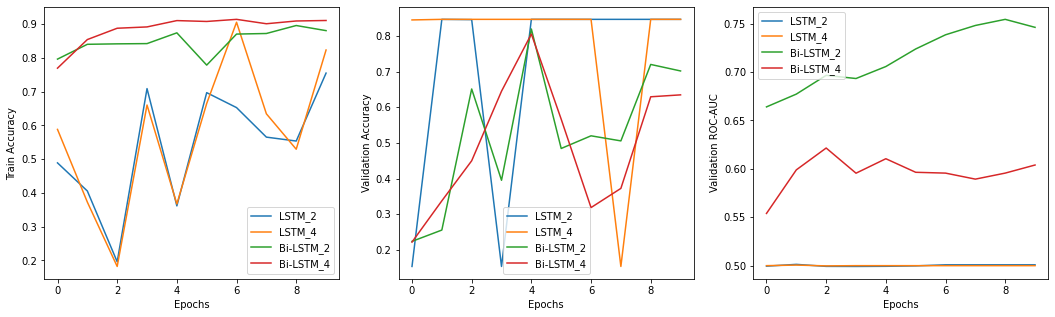

In [38]:
# Plotting the acurracy and roc auc for all the models

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(history1.history['accuracy'])
ax[0].plot(history2.history['accuracy'])
ax[0].plot(history3.history['accuracy'])
ax[0].plot(history4.history['accuracy'])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Train Accuracy")
ax[0].legend(['LSTM_2', 'LSTM_4', 'Bi-LSTM_2', 'Bi-LSTM_4'])

ax[1].plot(history1.history['val_accuracy'])
ax[1].plot(history2.history['val_accuracy'])
ax[1].plot(history3.history['val_accuracy'])
ax[1].plot(history4.history['val_accuracy'])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Validation Accuracy")
ax[1].legend(['LSTM_2', 'LSTM_4', 'Bi-LSTM_2', 'Bi-LSTM_4'])

ax[2].plot(history1.history['val_auc'])
ax[2].plot(history2.history['val_auc'])
ax[2].plot(history3.history['val_auc'])
ax[2].plot(history4.history['val_auc'])
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Validation ROC-AUC")
ax[2].legend(['LSTM_2', 'LSTM_4', 'Bi-LSTM_2', 'Bi-LSTM_4'])

In [2]:
history1.history.keys()

NameError: name 'history1' is not defined

In [1]:
# LSTM 2 layers
history1.history['accuracy'][9]
history1.history['val_accuracy'][9]
history1.history['val_auc'][9]
history1.history['val_loss'][9]
history1.history['val_precision'][9]
history1.history['val_recall'][9]

NameError: name 'history1' is not defined

In [41]:
# LSTM 4 layers
history2.history['accuracy'][9]
history2.history['val_accuracy'][9]
history2.history['val_auc'][9]
history2.history['val_precision'][9]
history2.history['val_recall'][9]

0.822998046875

0.8462499976158142

0.5

0.0

0.0

In [42]:
# Bi-LSTM 2 layers
history3.history['accuracy'][9]
history3.history['val_accuracy'][9]
history3.history['val_auc'][9]
history3.history['val_precision'][9]
history3.history['val_recall'][9]

0.88037109375

0.7016249895095825

0.7461358904838562

0.2870813310146332

0.6341463327407837

In [43]:
# Bi-LSTM 4 layers
history4.history['accuracy'][9]
history4.history['val_accuracy'][9]
history4.history['val_auc'][9]
history4.history['val_precision'][9]
history4.history['val_recall'][9]

0.910400390625

0.6346250176429749

0.6039486527442932

0.21178072690963745

0.5056910514831543

In [44]:
history1.history['val_auc'][9]
history2.history['val_auc'][9]
history3.history['val_auc'][9]
history4.history['val_auc'][9]

0.5008862614631653

0.5

0.7461358904838562

0.6039486527442932